In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [11]:
import arviz as az
import jax
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

numpyro.set_host_device_count(8)

A bit of discussion of what's going on here.  We assume that we have a set of samples of some parameters in $N$ dimensions for each event:
$$
\theta_{ijk},
$$
where $0 \leq i < N_\mathrm{evt}$, $0 \leq j < N_\mathrm{samples}$ (we use a "square" array of samples for convenience, but this could straightforwardly be made ragged at the cost of a bit more bookkeeping), and $0 \leq k < N$.  The samples are drawn according to some prior density, so come with a prior "weight," $\pi_{ij}$.

For some of these parameters, say (without loss of generality) the first $N_g \leq N$ of them, we wish to impose a multivariate Gaussian population with mean $\mathbf{\mu}$ and covariance matrix $\mathbf{\Sigma}$:
$$
p\left( \mathbf{\theta}_{k<N_g} \mid \mu\left(\Lambda\right), \Sigma\left(\Lambda \right) \right) = \frac{1}{\sqrt{\det 2 \pi \mathbf{\Sigma}}} \exp\left( -\frac{1}{2} \left( \theta_{k'} - \mu_{k'} \right) \left( \Sigma^{-1} \right)^{k' k} \left( \theta_{k} - \mu_k\right) \right).
$$
Suppose for the rest of the parameters, $N_g \leq k < N$, we want to use a different (arbitrary) population,
$$
p\left( \mathbf{\theta}_{k\geq N_g} \mid \Lambda \right).
$$
For full generality we have let the Gaussian mean and covariance parameters depend on $\Lambda$ though this complication will not be present in the code below.  (In words: we want the population of the first $k < N_g$ parameters to be *conditionally* Gaussian at fixed values of the other parameters.)

We can, of course, treat this in the usual hierarchical way, averaging the full population (a product of the multivariate normal components and the other population) over the samples to compute the per-event likelihood function.  But if we do this, we will "run out of samples" if $\mathbf{\Sigma}$ becomes small, because the population is restricted to a narrow region in parameter space, perhaps *between* any of the samples we have obtained.  Even if the failure is not this dramatic, we may still require very, very many samples in order to adequately represent the likelihood function on the scales over which the population varies (in particular, if the population is quite narrow, for a long time we will see our computing requirements grow super-linearly with catalog size, as each successive catalog produces fits to the population that are narrower and narrower).

The problem referred to above, though, is merely that the discrete samples do not do a good job of representing the (smooth on small scales) likelihood function.  (It is different from other causes of small effective sample number in the importance marginalization, like a mismatch between population and likelihood---outliers---in that, ultimately, we expect all likelihoods to be smooth on small scales, so it is not some fundamental issue of needing lots of samples to properly determine the likelihood, but rather just that any finite set of samples becomes discrete on some---rather large---scale.)  One way to fix this problem is to use a Gaussian KDE approximation to the likelihood function; such an approximation guarantees smoothness on small scales, and therefore completely solves the issue.

A Gaussian KDE approximation to the likelihood is *also* beneficial in that we can integrate the true parameter out of the likelihood analytically because the dependence of the posterior on $\theta_{k<N_g}$ is a product of Gaussians.  Let us factor the prior into a conditional term and marginal term:
$$
p\left( \theta_k \right) = p\left( \theta_{k < N_g} \mid \theta_{k \geq N_g} \right) p\left( \theta_{k \geq N_g} \right).
$$
Then the weight for each sample also factors 
$$
\pi_{ij} = \pi_{g,ij} \pi_{ng,ij},
$$
where 
$$
\pi_{g,ij} = p\left( \theta_{k<N_g} \mid \theta_{k \geq N_g} \right)
$$
is the conditional piece of the prior and $\pi_{ng,ij}$ is the marginal prior on the $N_g \leq k < N$ parameters. 

We want to represent the *conditional* likelihood function as a Gaussian KDE, leaving samples for the $k \geq N_g$ dimensions.  Choosing some bandwidth $\mathbf{\Sigma}_{bw,i}$ for each event $i$ (more on this below), we will approximate the likelihood:
$$
p\left( d_i \mid \theta_{ik} \right) \propto \frac{1}{W_i} \sum_j w_{ij} \phi\left( \theta_{ik<N_g} \mid \theta_{ijk<N_g}, \mathbf{\Sigma}_{bw,i} \right) \frac{\delta\left( \theta_{ik\geq N_g} - \theta_{ijk \geq N_g} \right)}{\pi_{ng,ij}},
$$
where $\phi\left( \mathbf{x} \mid \mathbf{\mu}, \mathbf{\Sigma} \right)$ is the multivariate normal density.  The weight factor $w_{ij} = 1/\pi_{g,ij}$ cancels the conditional prior on the Gaussian population component, and $\pi_{ng,ij}$ takes care of the non-Gaussian components.  $W_i \equiv \sum_j w_{ij}$ is a normalizing factor (that can be ignored during sampling).

Each event generates a term in the joint posterior like 
$$
p\left( d_i \mid \theta_{ik} \right) p\left( \theta_{ik<N_g} \mid \mu\left(\Lambda\right), \mathbf{\Sigma}\left(\Lambda\right) \right) p\left( \theta_{ik \geq N_g} \mid \Lambda \right).
$$
Integrating over $\theta_{ik}$, the (latent) true parameter $\theta$ for event $i$ and using our Gaussian KDE / delta-function approximation to the , we obtain
$$
\int \mathrm{d} \theta_{ik} \, p\left( d_i \mid \theta_{ik} \right) p\left( \theta_{ik<N_g} \mid \mu\left(\Lambda\right), \mathbf{\Sigma}\left(\Lambda\right) \right) p\left( \theta_{ik \geq N_g} \mid \Lambda \right) = \frac{1}{W_i} \sum_j w_{ij} \phi\left( \theta_{ijk<N_g} \mid \mathbf{\mu}, \mathbf{\Sigma} + \mathbf{\Sigma}_{bw,i} \right) \frac{p\left( \theta_{ijk \geq N_g} \mid \Lambda \right)}{\pi_{ng,ij}}.
$$
This likelihood function is implemented below.

The remaining trick is to choose the "right" bandwidth $\mathbf{\Sigma}_{bw,i}$ for each event's samples $i$.  For a Gaussian KDE, the standard Scott's rule is to choose 
$$
\Sigma_{bw} = \frac{\mathrm{cov} \left( \mathbf{\theta} \right)}{N_\mathrm{samples}^{2/(4 + N)}}.
$$
But for us, we only want to represent the *conditional* density (over $N_g \leq N$ dimensions) as a Gaussian KDE; and we have weights $w_{ij}$ that treat the samples non-uniformly.  A possible solution is to use in place of the full covariance the *conditional* covariance (which can be obtained by computing the full covariance, inverting the matrix, extracting the $N_g \times N_g$ upper left corner, and inverting *that* to obtain the covariance over $\theta_{k<N_g}$ with $\theta_{k \geq N_g}$ held fixed).  And, instead of using $N_\mathrm{samples}$ we use 
$$
N_{\mathrm{eff},i} = \frac{\left( \sum_j w_{ij} \right)^2}{\sum_j w_{ij}^2},
$$
and compute the *weighted* covariance.  This is the logic of the code below:

In [73]:
def make_partial_normal_normal_model(samples, prior_wts_normal, prior_wts_other, n_normal):
    nobs, nsamp, ndim = samples.shape
    n_other = ndim - n_normal
    assert prior_wts_normal.shape == (nobs, nsamp), 'incorrect shape in prior_wts_normal'
    assert prior_wts_other.shape == (nobs, nsamp), 'incorrect shape in prior_wts_other'

    # Here we compute the full covariance matrices for the each of the sets of samples:
    wts = 1/prior_wts_normal
    w = np.sum(wts, axis=1)
    theta_mus = np.sum(wts[:,:,None]*samples, axis=1) / w[:, None] # Shape is (nobs, ndim)
    theta_cov = np.sum(wts[:, :, None, None]*(samples[:, :, :, None] - theta_mus[:, None, :, None])*(samples[:, :, None, :] - theta_mus[:, None, None, :]), axis=1) / w[:, None, None] # shape (nobs, ndim, ndim)
    theta_cov_inv = np.linalg.inv(theta_cov) # (nobs, ndim, ndim)
    theta_cov_inv_normal = theta_cov_inv[:, :n_normal, :n_normal] # (nobs, n_normal, n_normal)
    theta_cov_normal = np.linalg.inv(theta_cov_inv_normal) # (nobs, n_normal, n_normal)

    log_normal_wts = np.log(wts) # (nobs, nsamp)
    log_normal_w = np.log(w) # (nobs,)
    log_other_wts = np.log(prior_wts_other) # (nobs, nsamp)

    neff = np.square(np.sum(wts, axis=1)) / np.sum(np.square(wts), axis=1)
    kde_bw = theta_cov_normal / neff[:,None,None]**(2 / (4 + n_normal)) # Scott's rule; shape is (nobs, n_normal, n_normal)

    mu = numpyro.sample('mu', dist.Normal(0, 1), sample_shape=(n_normal,))
    sigma_scales = numpyro.sample('sigma_scales', dist.HalfNormal(1), sample_shape=(n_normal,))
    sigma_corr = numpyro.sample('sigma_corr', dist.LKJ(n_normal, 2))
    Sigma = numpyro.deterministic('Sigma', sigma_scales[:,None]*sigma_corr*sigma_scales[None, :])

    _ = numpyro.deterministic('sqrt_Sigma_diag', jnp.sqrt(jnp.diag(Sigma)))

    alpha = numpyro.sample('alpha', dist.Uniform(1, 4))

    sigma_evts = kde_bw + Sigma[None, :, :]
    logp_normal = dist.MultivariateNormal(mu[None, None, :], sigma_evts[:, None, :, :]).log_prob(samples[:,:,:n_normal])

    logp_other = -(alpha+1)*jnp.log(samples[:,:,-1]) + jnp.log(alpha)

    logp_total = logp_normal + log_normal_wts - log_normal_w[:, None] + logp_other - log_other_wts
    logp_max_1 = jnp.max(logp_total, axis=1)
    logp_summed = logp_max_1 + jnp.log(jnp.sum(jnp.exp(logp_total - logp_max_1[:, None]), axis=1))

    numpyro.factor('log_likelihood', jnp.sum(logp_summed))

In [110]:
nobs = 256
nsamp = 256
nnormal = 3
ndim = 4

alpha_true = 2

# Our true population is zero-mean, delta function in the first dimension, small-ish variation in the other two
mu_true = np.zeros(nnormal)
cov_true = np.diag(np.square([0.001, 0.1, 0.02]))

true_params = np.concatenate((np.random.multivariate_normal(mu_true, cov_true, size=nobs), np.random.pareto(alpha_true, size=nobs)[:,None]+1), axis=1)

In [120]:
samples = []
for i in range(nobs):
    p = true_params[i,:]

    # A random covariance matirx with more-or-less unit scale, but crazy correlations.
    Sigma = np.square(0.1)*np.diag(np.ones(4))

    p_obs = p + np.random.multivariate_normal(np.zeros(ndim), Sigma)

    # Because the observation is just the true parameters with additive Gaussian
    # noise, the likelihood function is Gaussian as well, with the same Sigma,
    # centered at the observed values.  There is a prior constraint that the
    # pareto parameter cannot be less than one, so we re-sample until all our
    # draws satisfy that constraint.
    p_samples = np.random.multivariate_normal(p_obs, Sigma, size=nsamp)
    while np.any(p_samples[:, -1] < 1):
        s = p_samples[:,-1] < 1
        p_samples[s, :] = np.random.multivariate_normal(p_obs, Sigma, size=np.sum(s))
    
    samples.append(p_samples)
samples = np.array(samples)

# We used a flat prior, so the weights are just a constant.
wts_normal = np.ones((nobs, nsamp))
wts_other = np.ones((nobs, nsamp))

In [121]:
nmcmc = 1000
nchain = 4

kernel = NUTS(make_partial_normal_normal_model)
mcmc = MCMC(kernel, num_warmup=nmcmc, num_samples=nmcmc, num_chains=nchain)
mcmc.run(jax.random.PRNGKey(42), samples, wts_normal, wts_other, nnormal)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [122]:
trace = az.from_numpyro(mcmc)

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sqrt_Sigma_diag'}>,
        <Axes: title={'center': 'sqrt_Sigma_diag'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

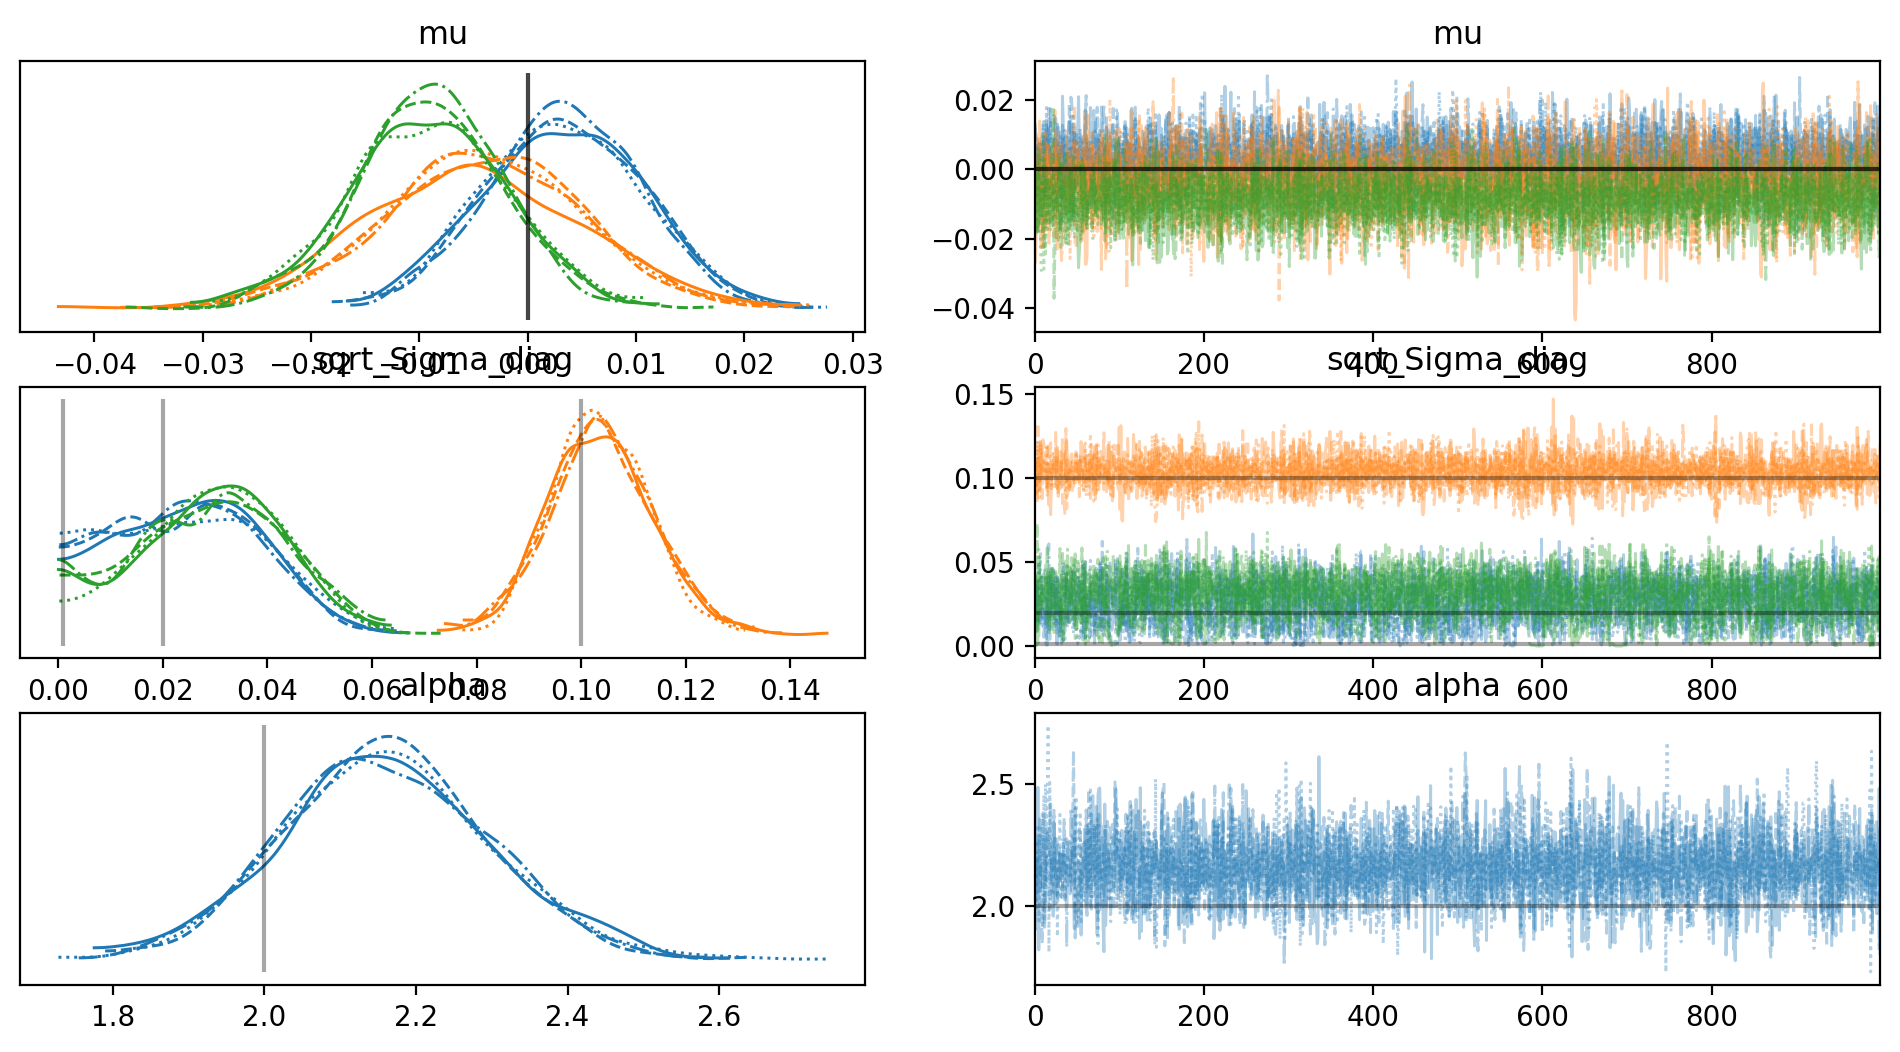

In [123]:
az.plot_trace(trace, var_names=['mu', 'sqrt_Sigma_diag', 'alpha'], lines=[('sqrt_Sigma_diag', {}, np.sqrt(np.diag(cov_true))), ('mu', {}, mu_true), ('alpha', {}, alpha_true)])

array([[<Axes: title={'center': 'mu\n0'}>,
        <Axes: title={'center': 'mu\n1'}>,
        <Axes: title={'center': 'mu\n2'}>],
       [<Axes: title={'center': 'sqrt_Sigma_diag\n0'}>,
        <Axes: title={'center': 'sqrt_Sigma_diag\n1'}>,
        <Axes: title={'center': 'sqrt_Sigma_diag\n2'}>],
       [<Axes: title={'center': 'alpha'}>, <Axes: >, <Axes: >]],
      dtype=object)

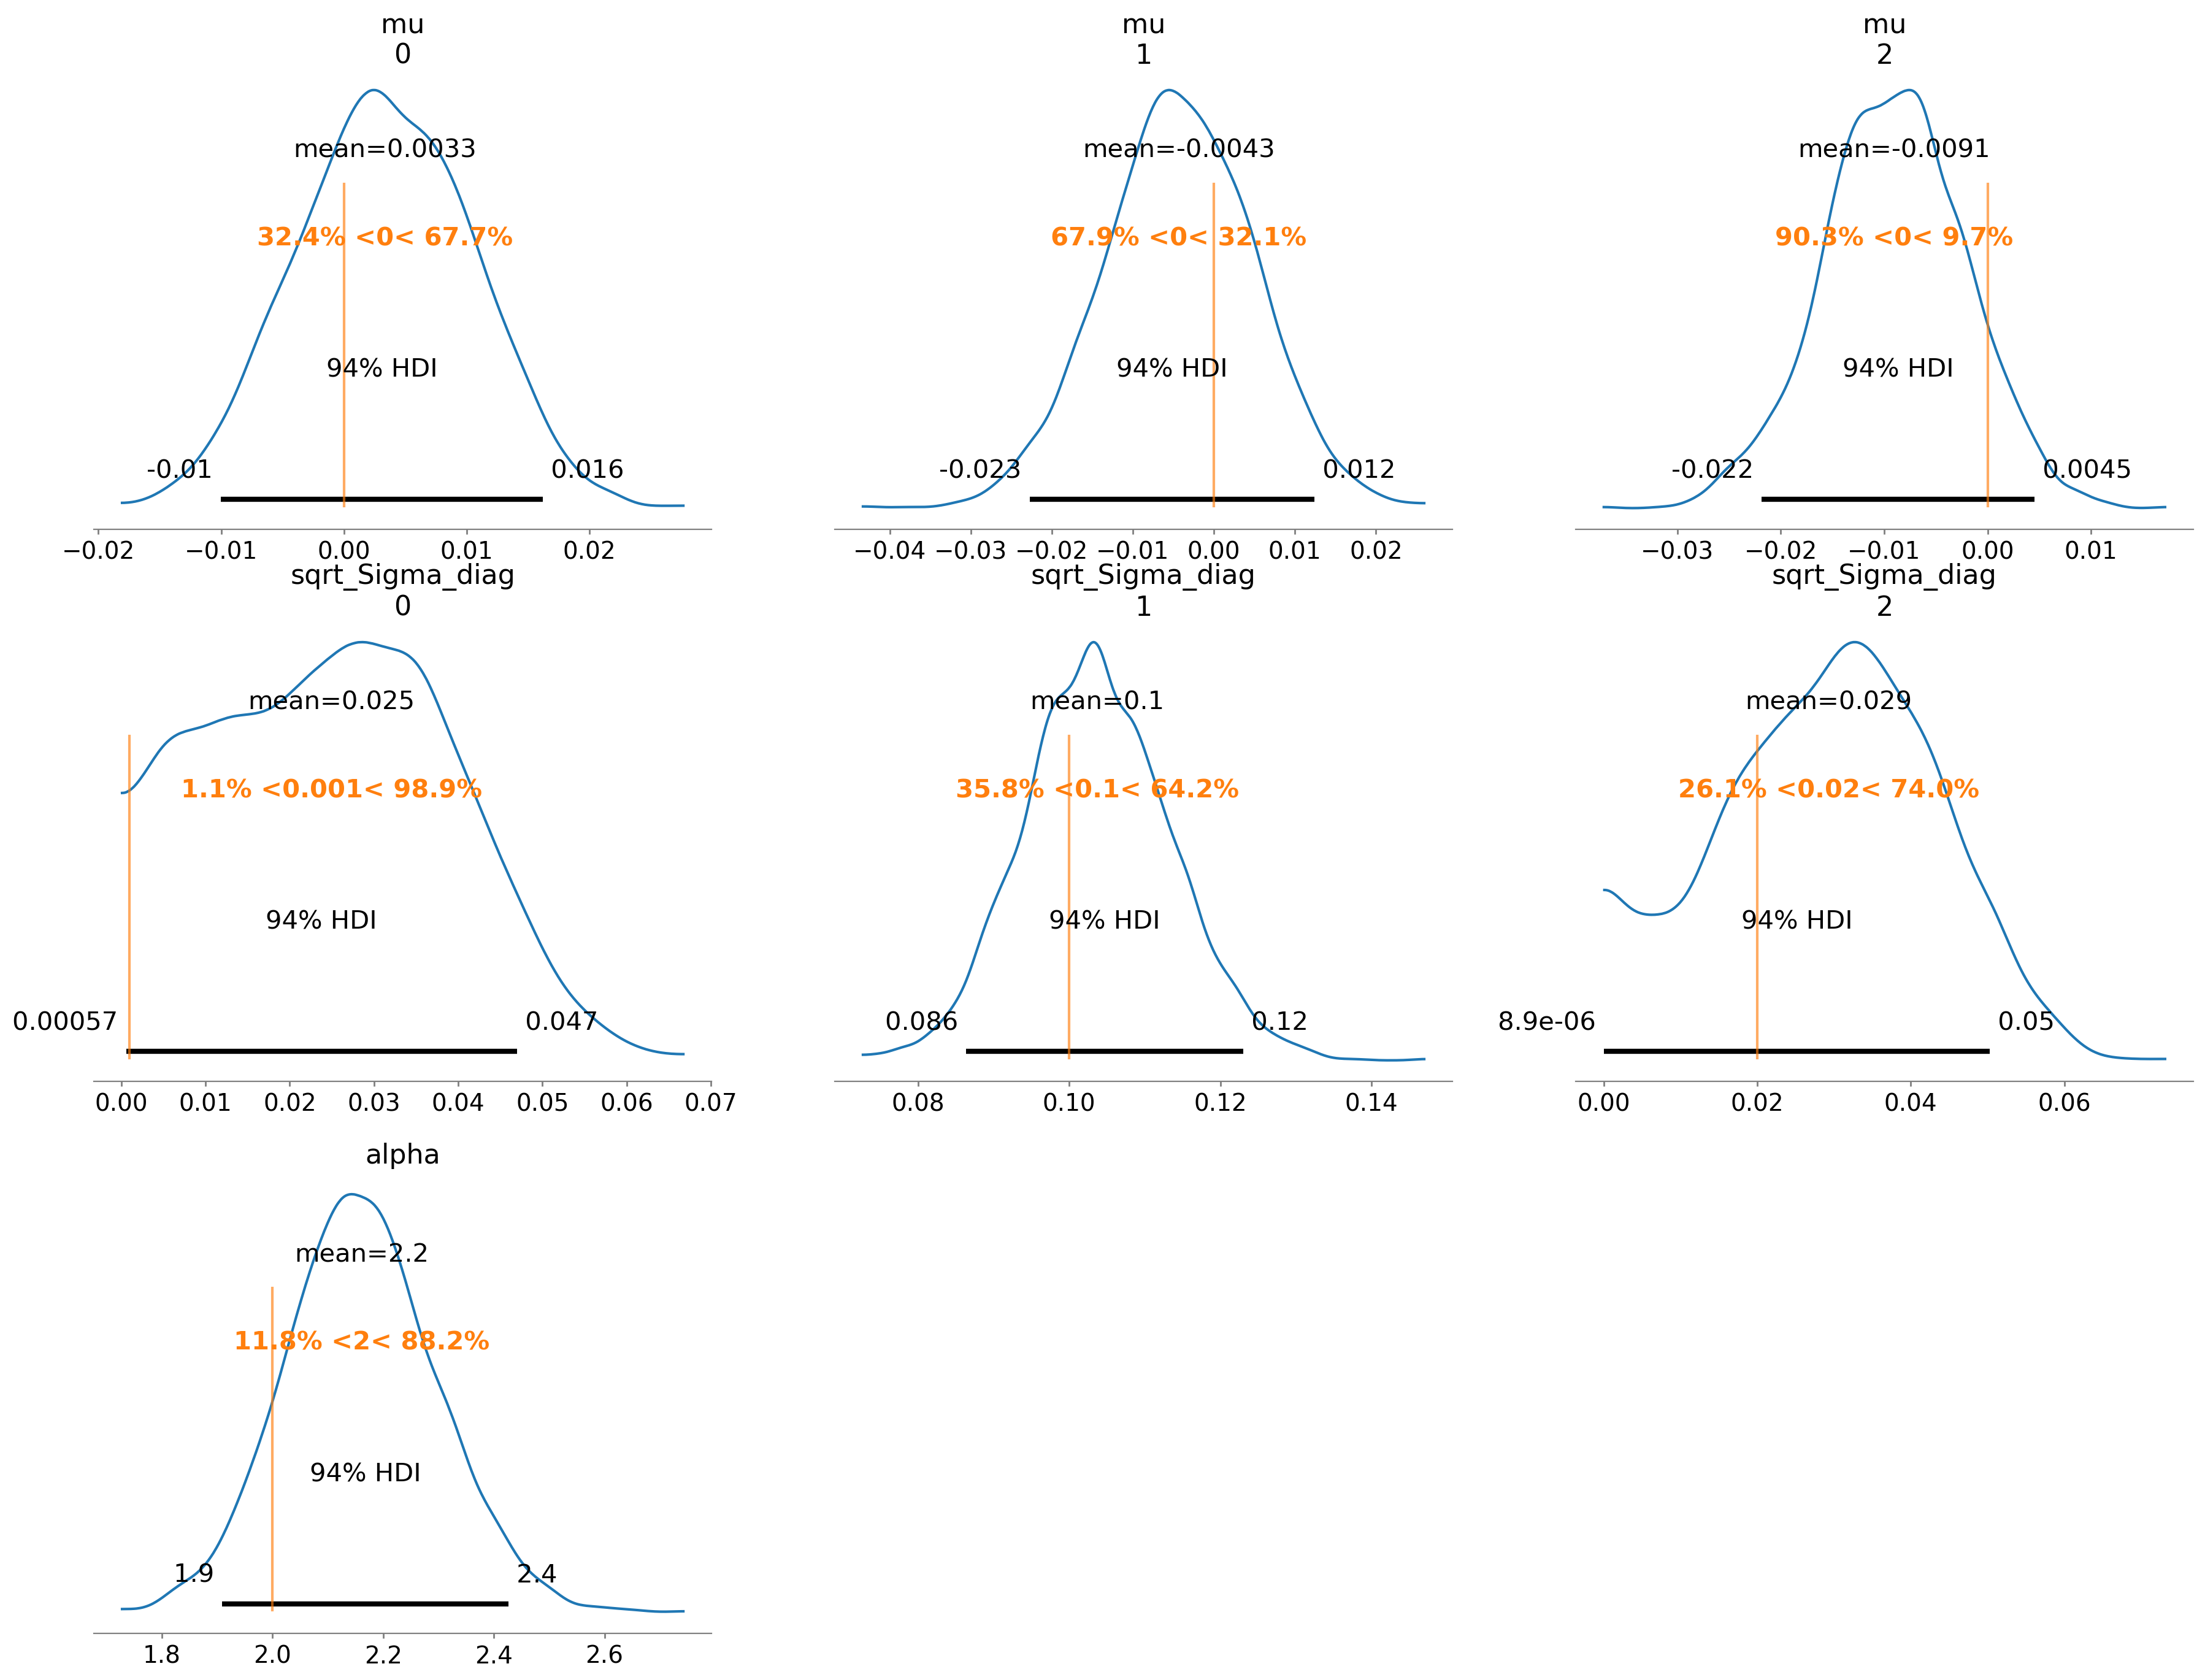

In [124]:
az.plot_posterior(trace, var_names=['mu', 'sqrt_Sigma_diag', 'alpha'], ref_val=list(mu_true) + list(np.sqrt(np.diag(cov_true))) + [alpha_true])